In [184]:
import numpy as np
from filterpy.kalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import quaternion
from mpl_toolkits.mplot3d import Axes3D
import math


# Orientation estimation using extended kalman filter
  Based on: X. Yun and E. R. Bachmann, ‘Design, Implementation, and Experimental Results of a Quaternion-Based Kalman Filter for Human Body Motion Tracking’, IEEE Trans. Robot., vol. 22, no. 6, pp. 1216–1227, Dec. 2006, doi: 10.1109/TRO.2006.886270.
  
The state vector contains 3D angular velocity and quaternion: $$
\vec{x} = \begin{pmatrix} \omega_x & \omega_y & \omega_z & q_1 & q_2 & q_3 & q_4 \end{pmatrix}^T
$$


In [185]:
# this is the Jacobian (linearized version) of the state transition, equation (13)
def phi(x, Ts, tau1, tau2, tau3):
    return np.array([[np.exp(-Ts/tau1), 0, 0, 0, 0, 0, 0],
                    [0, np.exp(-Ts/tau2), 0, 0, 0, 0, 0],
                    [0, 0, np.exp(-Ts/tau3), 0, 0, 0, 0],
                    [-(x[4]*Ts)/2, -(x[5]*Ts)/2, -(x[6]*Ts)/2, 1, -(x[0]*Ts)/2, -(x[1]*Ts)/2, -(x[2]*Ts)/2],
                    [(x[3]*Ts)/2, -(x[6]*Ts)/2, (x[5]*Ts)/2, (x[0]*Ts)/2, 1, (x[2]*Ts)/2, -(x[1]*Ts)/2],
                    [(x[6]*Ts)/2, (x[3]*Ts)/2, -(x[4]*Ts)/2, (x[1]*Ts)/2, -(x[2]*Ts)/2, 1, (x[0]*Ts)/2],
                    [-(x[5]*Ts)/2, (x[4]*Ts)/2, (x[3]*Ts)/2, (x[2]*Ts)/2, (x[1]*Ts)/2, -(x[0]*Ts)/2, 1]])

def quaternion_to_matrix(q):
    w, x, y, z = q
    return np.array([
        [1 - 2 * y ** 2 - 2 * z ** 2, 2 * x * y - 2 * z * w, 2 * x * z + 2 * y * w],
        [2 * x * y + 2 * z * w, 1 - 2 * x ** 2 - 2 * z ** 2, 2 * y * z - 2 * x * w],
        [2 * x * z - 2 * y * w, 2 * y * z + 2 * x * w, 1 - 2 * x ** 2 - 2 * y ** 2]
    ])

def normalize_quaternion(q):
    norm = np.linalg.norm(q)
    if norm > 1e-10:
       q = q / norm
    return q
        
def update_velocity(v, accel, R, Ts):
    # transform to world frame
    accel_world = R @ accel
    # integrate acceleration to velocity
    v_new = v + accel_world * Ts
    return v_new

# https://automaticaddison.com/how-to-convert-a-quaternion-into-euler-angles-in-python/
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = math.atan2(t0, t1)
     
        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch_y = math.asin(t2)
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = math.atan2(t3, t4)
     
        return roll_x, pitch_y, yaw_z # in radians


In [186]:
kf = KalmanFilter(dim_x=7,dim_z=7)
kf.x = np.array([0,0,0,0,0,0,0])
Ts = 0.04  # 25Hz samples

kf.H = np.eye(7)

tau1 = 0.7
tau2 = 0.7
tau3 = 0.7
D = 0.0000001

q11 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau1))
q22 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau2))
q33 = (D/(2*tau1))*(1 - np.exp(-(2*Ts)/tau3))
q_quat = 0.01

kf.Q = np.array([
    [0.00456651466, -0.00102874117, 0, 0, 0, 0, 0],
    [-0.00102874117, 0.00901927163, -0.00104132302, 0, 0, 0, 0],
    [0, -0.00104132302, 0.00596346074, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0]])

kf.R =  np.array([
    [0.0045610, 0, 0, 0, 0, 0, 0],
    [0, 0.00900853, 0, 0, 0, 0, 0],
    [0, 0, 0.00595636, 0, 0, 0, 0],
    [0, 0, 0, 0.001, 0, 0, 0],
    [0, 0, 0, 0, 0.001, 0, 0],
    [0, 0, 0, 0, 0, 0.001, 0],
    [0, 0, 0, 0, 0, 0, 0.001]])

kf.P *= 1000

In [187]:
df_stationary = pd.read_csv('spiral_data/sensor_stand_still.csv')
Ax_Bias = df_stationary['a_x'].mean()
Ay_Bias = df_stationary['a_y'].mean()
Az_Bias = df_stationary['a_z'].mean()
Gx_Bias = df_stationary['omega_x'].mean()
Gy_Bias = df_stationary['omega_y'].mean()
Gz_Bias = df_stationary['omega_z'].mean()

In [188]:
predicted_roll=[]
predicted_pitch = [] 
predicted_yaw = []
measured_roll = []
measured_pitch = []
measured_yaw = []

df = pd.read_csv('spiral_data/sensor_data_up_b.csv')
v=np.array([0.0,0,0])
for i, row in df.iterrows():
    z = [row['Gyro_X']*(np.pi/180),
         row['Gyro_Y']*(np.pi/180),
         row['Gyro_Z']*(np.pi/180),
         row['Quaternion_W'], 
         row['Quaternion_X'], 
         row['Quaternion_Y'], 
         row['Quaternion_Z']]
    
    z[3:7] = normalize_quaternion(z[3:7])
    roll, pitch, yaw = euler_from_quaternion(z[3], z[4], z[5], z[6])
    measured_roll.append(roll)
    measured_pitch.append(pitch)
    measured_yaw.append(yaw)
    
    kf.F = phi(kf.x, Ts, tau1, tau2, tau3)  
    kf.predict()
    x = kf.x
    roll, pitch, yaw = euler_from_quaternion(x[3], x[4], x[5], x[6])
    predicted_roll.append(roll)
    predicted_pitch.append(pitch)
    predicted_yaw.append(yaw)
    kf.update(z)

predicted_roll = np.array(predicted_roll)
predicted_pitch = np.array(predicted_pitch)
predicted_yaw = np.array(predicted_yaw)
measured_roll = np.array(measured_roll)
measured_pitch = np.array(measured_pitch)
measured_yaw = np.array(measured_yaw)

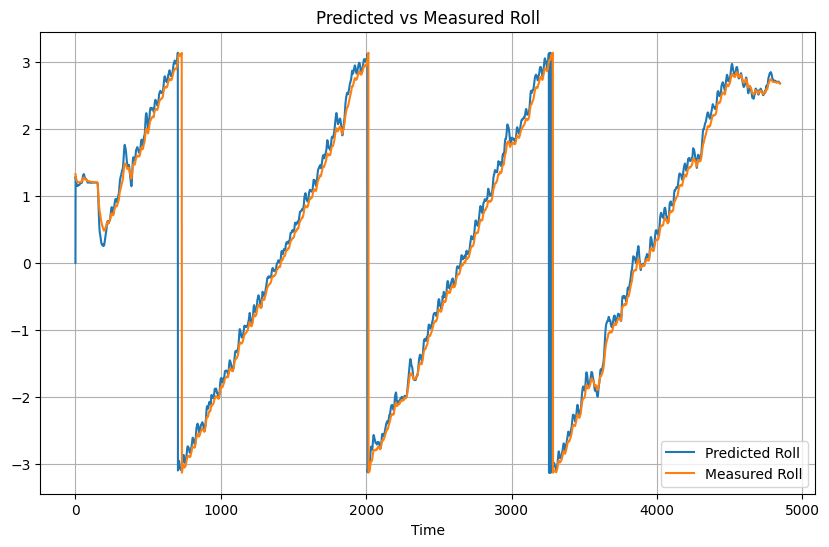

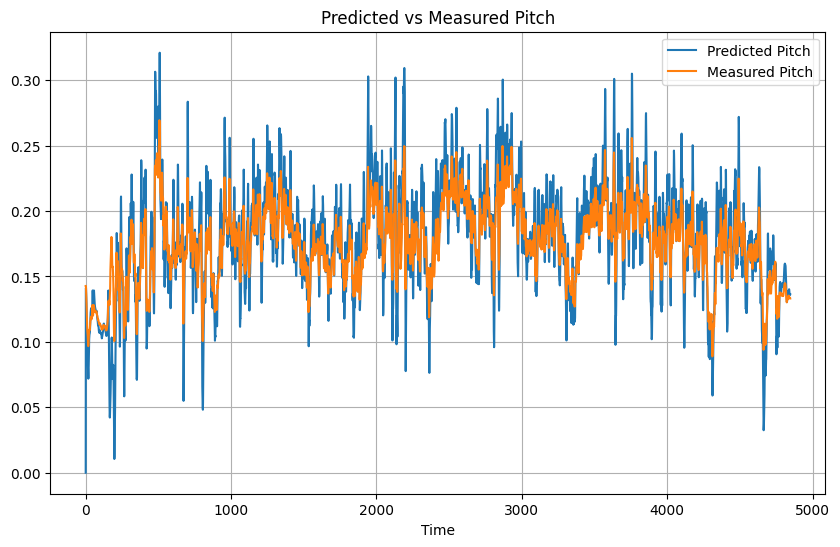

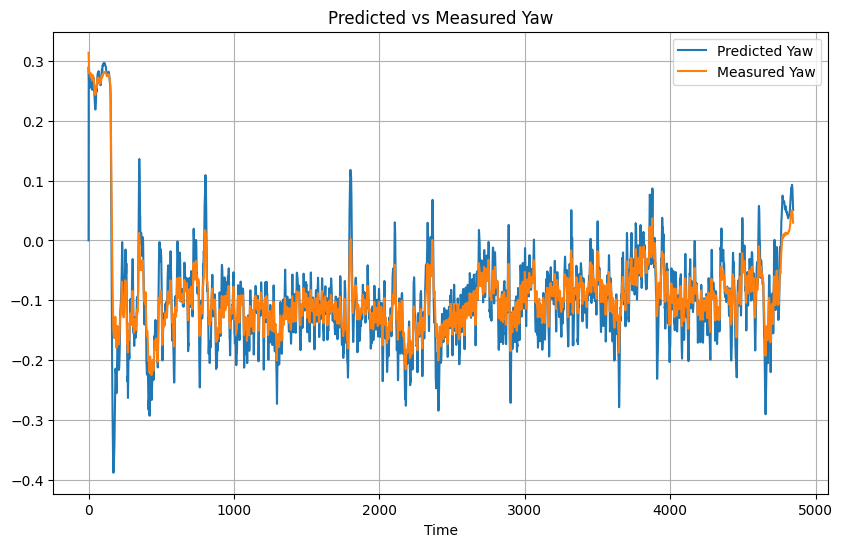

In [189]:
plt.figure(figsize=(10, 6))
plt.plot( predicted_roll, label='Predicted Roll')
plt.plot(measured_roll, label='Measured Roll')
plt.xlabel('Time')
plt.title('Predicted vs Measured Roll')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot( predicted_pitch, label='Predicted Pitch')
plt.plot(measured_pitch, label='Measured Pitch')
plt.xlabel('Time')
plt.title('Predicted vs Measured Pitch')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot( predicted_yaw, label='Predicted Yaw')
plt.plot(measured_yaw, label='Measured Yaw')
plt.xlabel('Time')
plt.title('Predicted vs Measured Yaw')
plt.legend()
plt.grid()
plt.show()
